# Tutorial: Analyze functional dependencies in a Power BI sample dataset

In this tutorial, you build upon prior work done by a Power BI analyst and stored in the form of datasets. By using SemPy in the Synapse Data Science experience within Microsoft Fabric, you analyze functional dependencies that exist in columns of a DataFrame. This analysis helps to discover non-trivial data quality issues in order to gain more accurate insights.


### In this tutorial, you learn how to:
- Apply domain knowledge to formulate hypotheses about functional dependencies in a dataset.
- Get familiarized with components of Semantic Link's Python library ([SemPy](https://learn.microsoft.com/en-us/python/api/semantic-link-sempy)) that supports integration with Power BI and helps to automate data quality analysis. These components include:
    - FabricDataFrame - a pandas-like structure enhanced with additional semantic information.
    - Useful functions for pulling Power BI datasets from a Fabric workspace into your notebook.
    - Useful functions that automate the evaluation of hypotheses about functional dependencies and that identify violations of relationships in your datasets.

### Prerequisites

* A [Microsoft Fabric subscription](https://learn.microsoft.com/fabric/enterprise/licenses). Or sign up for a free [Microsoft Fabric (Preview) trial](https://learn.microsoft.com/fabric/get-started/fabric-trial).
* Sign in to [Microsoft Fabric](https://fabric.microsoft.com/).
* Go to the Data Science experience in Microsoft Fabric.
* Select **Workspaces** from the left navigation pane to find and select your workspace. This workspace becomes your current workspace.
* Download the _Customer Profitability Sample.pbix_ dataset from the [fabric-samples GitHub repository](https://github.com/microsoft/fabric-samples/blob/main/docs-samples/data-science/datasets/Customer%20Profitability%20Sample.pbix) and upload it to your workspace.
* Open your notebook. You have two options:
    * [Import this notebook into your workspace](https://learn.microsoft.com/en-us/fabric/data-engineering/how-to-use-notebook#import-existing-notebooks). You can import from the Data Science homepage.
    * Alternatively, you can create [a new notebook](https://learn.microsoft.com/fabric/data-engineering/how-to-use-notebook#create-notebooks) to copy/paste code into cells.
* In the Lakehouse explorer section of your notebook, add a new or existing lakehouse to your notebook. For more information on how to add a lakehouse, see [Attach a lakehouse to your notebook](https://learn.microsoft.com/en-us/fabric/data-science/tutorial-data-science-prepare-system#attach-a-lakehouse-to-the-notebooks).

## Set up the notebook

In this section, you set up a notebook environment with the necessary modules and data.

1. Install `SemPy` from PyPI using the `%pip` in-line installation capability within the notebook:

In [ ]:
%pip install semantic-link

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, -1, Finished, Available)


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: /nfs4/pyenv-438609e1-eb5b-46ac-a065-9eb6a8b9c7b8/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


2. Perform necessary imports of modules that you'll need later:

In [ ]:
import sempy.fabric as fabric
from sempy.dependencies import plot_dependency_metadata

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 17, Finished, Available)

## Load and preprocess the data

This tutorial uses a standard Power BI sample dataset [Customer Profitability Sample.pbix](https://github.com/microsoft/fabric-samples/tree/main/docs-samples/data-science/datasets). For a description of the dataset, see [Customer Profitability sample for Power BI](https://learn.microsoft.com/en-us/power-bi/create-reports/sample-customer-profitability).

Load the Power BI data into FabricDataFrames, using SemPy's `read_table` function:

In [ ]:
dataset = "Customer Profitability Sample"
customer = fabric.read_table(dataset, "Customer")
customer.head()

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 18, Finished, Available)

,Customer,Name,City,Postal Code,State,Industry ID,Country/Region
0,1023,Spade and Archer,Irving,75038,TX,31,US
1,10000,Globo-Chem,Chicago,60601,IL,30,US
2,10001,SNC Directly to America,Westchester,60154,IL,30,US
3,10002,GHG,Plano,75024,TX,13,US
4,10003,ABC Helicopter,Fort Worth,76177,TX,34,US


Load the `State` table into a FabricDataFrame:

In [ ]:
state = fabric.read_table(dataset, "State")
state.head()

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 19, Finished, Available)

,StateCode,State,Region
0,AK,ALASKA,WEST
1,FL,FLORIDA,EAST
2,GA,GEORGIA,EAST
3,HI,HAWAII,WEST
4,IA,IOWA,NORTH


While the output looks like a pandas DataFrame, you actually initialized a data structure called a ``FabricDataFrame`` that supports some useful operations on top of pandas.

In [ ]:
type(customer)

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 20, Finished, Available)

sempy.fabric._dataframe._fabric_dataframe.FabricDataFrame

Join the `customer` and `state` DataFrames:

In [ ]:
customer_state_df = customer.merge(state, left_on="State", right_on="StateCode",  how='left')
customer_state_df.head()

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 21, Finished, Available)

,Customer,Name,City,Postal Code,State_x,Industry ID,Country/Region,StateCode,State_y,Region
0,1023,Spade and Archer,Irving,75038,TX,31,US,TX,TEXAS,SOUTH
1,10000,Globo-Chem,Chicago,60601,IL,30,US,IL,ILLINOIS,NORTH
2,10001,SNC Directly to America,Westchester,60154,IL,30,US,IL,ILLINOIS,NORTH
3,10002,GHG,Plano,75024,TX,13,US,TX,TEXAS,SOUTH
4,10003,ABC Helicopter,Fort Worth,76177,TX,34,US,TX,TEXAS,SOUTH


## Identify functional dependencies

A functional dependency manifests itself as a one-to-many relationship between the values in two (or more) columns within a DataFrame. These relationships can be used to automatically detect data quality problems. 

Run SemPy's `find_dependencies` function on the merged DataFrame to identify any existing functional dependencies between values in the columns:

In [ ]:
dependencies = customer_state_df.find_dependencies()
dependencies

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 22, Finished, Available)

,Determinant,Dependent,Conditional Entropy,Determinant Unique Count,Dependent Unique Count,Determinant Null Count,Dependent Null Count
0,Customer,Name,0.000000,327,303,0,0
1,Customer,Postal Code,0.000000,327,208,0,50
2,Customer,City,0.000000,327,188,0,0
3,Customer,State_x,0.000000,327,37,0,0
4,Customer,Industry ID,0.000000,327,32,0,0
5,Name,Country/Region,0.004239,303,4,0,0
6,State_x,"[StateCode, State_y]",0.000000,37,34,0,13
7,State_x,Country/Region,0.000000,37,4,0,0
8,"[StateCode, State_y]",Region,0.000000,34,6,13,13


Visualize the identified dependencies by using SemPy's ``plot_dependency_metadata`` function:

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 23, Finished, Available)

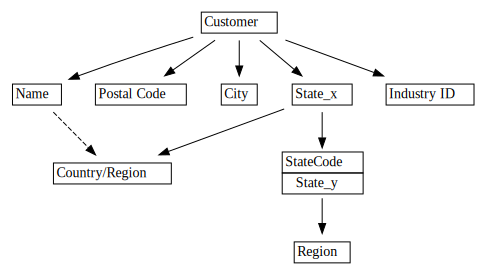

In [ ]:
plot_dependency_metadata(dependencies)

As expected, the functional dependencies graph shows that the `Customer` column determines some columns like `City`, `Postal Code`, and `Name`. 

Surprisingly, the graph doesn't show a functional dependency between `City` and `Postal Code`, probably because there are many violations in the relationships between the columns. You can use SemPy's ``plot_dependency_violations`` function to visualize violations of dependencies between specific columns.

## Explore the data for quality issues

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 24, Finished, Available)

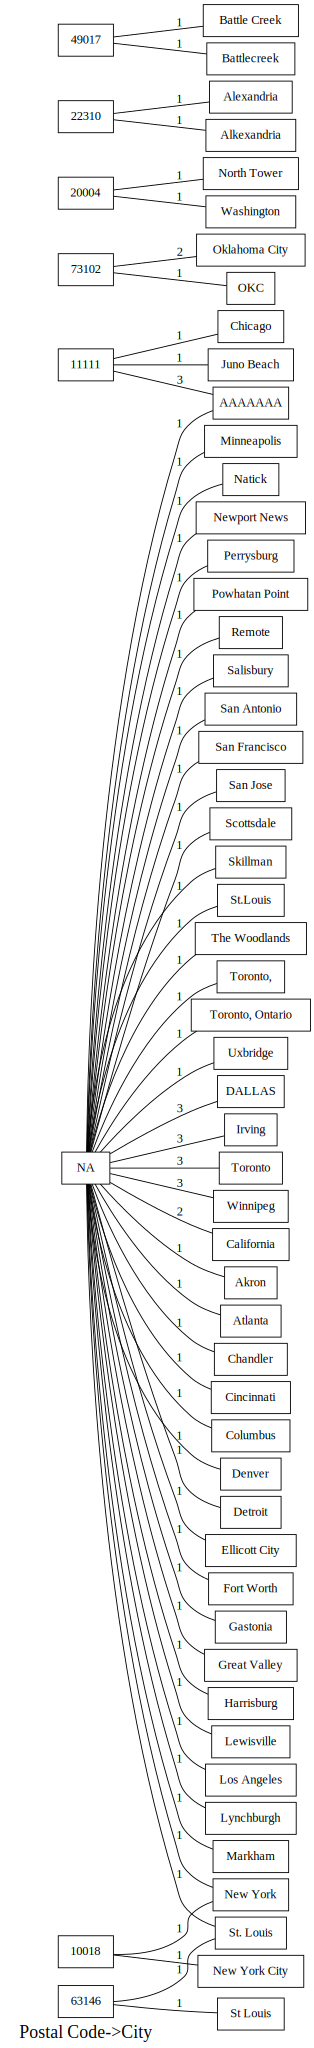

In [ ]:
customer_state_df.plot_dependency_violations('Postal Code', 'City')

The plot of dependency violations shows values for `Postal Code` on the left hand side, and values for `City` on the right hand side. An edge connects a `Postal Code` on the left with a `City` on the right if there is a row that contains these two values. The edges are annotated with the count of such rows. For example, there are two rows with postal code 20004, one with city "North Tower" and the other with city "Washington".

Moreover, the plot shows a few violations and many empty values.

In [ ]:
customer_state_df['Postal Code'].isna().sum()

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 25, Finished, Available)

50

50 rows have NA for postal code. 

Next, drop rows with empty values. Then, find dependencies using the `find_dependencies` function. Notice the additional parameter `verbose=1` that offers a glimpse into the internal workings of SemPy:

In [ ]:
customer_state_df2=customer_state_df.dropna()
customer_state_df2.find_dependencies(verbose=1)

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 26, Finished, Available)

State_x, StateCode: nunique 33, 33
Mapping size 33, dependency: True
State_x, State_y: nunique 33, 33
Mapping size 33, dependency: True

Dependencies for 10 columns 8 groups 275 rows, dropna=False, threshold=0.01
Region, Country/Region: cardinality shortcut: 0.0, 1.0
Region, Country/Region: conditional entropy 0.0, 1.0
Industry ID, Region: cached calculation 2.9751958829576504, 1.4548338980405395, 0.35134562333349867
Industry ID, Region: conditional entropy 1.103488274707041, 2.6238502596241515
Industry ID, Country/Region: cardinality shortcut: 0.0, 1.0
Industry ID, Country/Region: conditional entropy 0.0, 1.0
State_x, Industry ID: cached calculation 2.9883008304144907, 2.9751958829576504, 1.1575667522391768
State_x, Industry ID: conditional entropy 1.8176291307184735, 1.8307340781753139
State_x, Region: cached calculation 2.9883008304144907, 1.4548338980405395, 1.4548338980405395
State_x, Region: conditional entropy 0.0, 1.5334669323739512
State_x, Country/Region: indirectly dependent

,Determinant,Dependent,Conditional Entropy,Determinant Unique Count,Dependent Unique Count,Determinant Null Count,Dependent Null Count
0,Customer,Name,0.0,275,256,0,0
1,Customer,Postal Code,0.0,275,205,0,0
2,Customer,City,0.0,275,165,0,0
3,Customer,"[State_x, StateCode, State_y]",0.0,275,33,0,0
4,Customer,Industry ID,0.0,275,32,0,0
5,Name,Country/Region,0.0,256,1,0,0
6,Postal Code,Country/Region,0.0,205,1,0,0
7,City,Country/Region,0.0,165,1,0,0
8,"[State_x, StateCode, State_y]",Region,0.0,33,5,0,0
9,Industry ID,Country/Region,0.0,32,1,0,0


The conditional entropy for `Postal Code` and `City` is 0.049. This value can be explained by the fact there are functional dependency violations. Before you fix the violations, raise the threshold on conditional entropy from the default value of `0.01` to `0.05`, just to see the dependencies. Lower thresholds result in fewer dependencies (or higher selectivity).

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 27, Finished, Available)

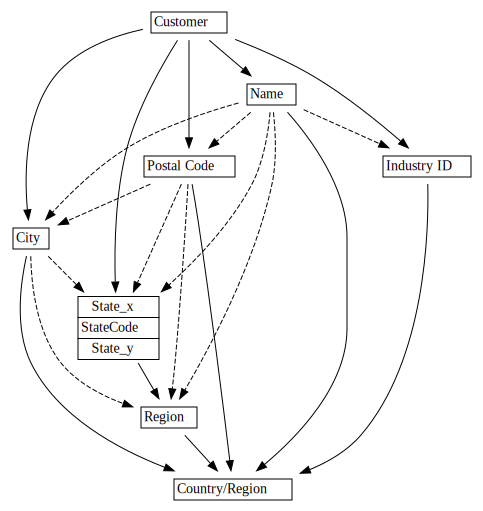

In [ ]:
plot_dependency_metadata(customer_state_df2.find_dependencies(threshold=0.05))

If you apply domain knowledge of which entity determines values of other entities, this dependencies graph seems accurate. 

Now, explore more data quality issues that were detected. For example, `City` and `Region` are joined by a dashed arrow, which indicates that the dependency is only approximate. This could imply that there is a partial functional dependency.

In [ ]:
customer_state_df.list_dependency_violations('City', 'Region')

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 28, Finished, Available)

,City,Region,count
0,AAAAAAA,SOUTH,3
1,AAAAAAA,NaN,1
2,Downers Grove,CENTRAL,1
3,Downers Grove,NORTH,1
4,Fremont,SOUTH,1
5,Fremont,WEST,1
6,Uxbridge,EAST,1
7,Uxbridge,NaN,1


Take a closer look at each of the cases where a non-empty `Region` value causes a violation:

In [ ]:
customer_state_df[customer_state_df.City=='Downers Grove']

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 29, Finished, Available)

,Customer,Name,City,Postal Code,State_x,Industry ID,Country/Region,StateCode,State_y,Region
66,10114,SNC Downers Grove,Downers Grove,60515,NE,30,US,NE,NEBRASKA,CENTRAL
249,50128,SNC Downers Grove,Downers Grove,60515,IL,30,US,IL,ILLINOIS,NORTH


Downers Grove is a [city in Illinois](https://en.wikipedia.org/wiki/Downers_Grove,_Illinois), not Nebraska.

In [ ]:
customer_state_df[customer_state_df.City=='Fremont']

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 30, Finished, Available)

,Customer,Name,City,Postal Code,State_x,Industry ID,Country/Region,StateCode,State_y,Region
37,10036,Horn BPO,Fremont,94555,TX,30,US,TX,TEXAS,SOUTH
46,10060,Soneli Graphics,Fremont,94538,CA,13,US,CA,CALIFORNIA,WEST


There is a city called [Fremont in California](https://en.wikipedia.org/wiki/Fremont,_California). However, for Texas, the search engine returns [Premont](https://en.wikipedia.org/wiki/Premont,_Texas), not Fremont!

It's also suspicious to see violations of the dependency between `Name` and `Country/Region`, as signified by the dotted line in the original graph of dependency violations (before dropping the rows with empty values).

In [ ]:
customer_state_df.list_dependency_violations('Name', 'Country/Region')

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 31, Finished, Available)

,Name,Country/Region,count
0,SDI Design,CA,1
1,SDI Design,US,1


It appears that one customer, 'SDI Design' is present in two regions - United States and Canada. This may not be a semantic violation, but may just be an uncommon case. Still, it's worth taking a close look:

In [ ]:
customer_state_df[customer_state_df.Name=='SDI Design']

StatementMeta(, e5370855-62aa-42f8-bdac-08820d8f9c7a, 32, Finished, Available)

,Customer,Name,City,Postal Code,State_x,Industry ID,Country/Region,StateCode,State_y,Region
128,10203,SDI Design,Denver,80222,CO,15,US,CO,COLORADO,CENTRAL
323,50233,SDI Design,Winnipeg,<NA>,MB,30,CA,NaN,NaN,NaN


Further inspection shows that it's actually two different customers (from different industries) with the same name.

Exploratory data analysis is an exciting process, and so is data cleaning. There's always something that the data is hiding, depending on how you look at it, what you want to ask, and so on. Semantic Link provides you with new tools that you can use to achieve more with your data. 

## Related content

Check out other tutorials for Semantic Link / SemPy:
1. Clean data with functional dependencies
1. Discover relationships in the _Synthea_ dataset using Semantic Link
1. Discover relationships in a Power BI dataset using Semantic Link
1. Extract and calculate Power BI measures from a Jupyter notebook